<a href="https://colab.research.google.com/github/archie-cm/Training-Course/blob/main/ml_archiecm_dicoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Nama : Archie Citra M
*   Email : archiecm22@gmail.com
*   Username : archiecm
*   Kota domisili : Sragen

# Import Libraries

In [ ]:
from io import BytesIO
from IPython.display import Image as IMG
from google.colab import files
from keras.preprocessing import image
from shutil import copyfile
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlopen
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import zipfile, os
import warnings
warnings.filterwarnings("ignore")

!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.0 MB/s 
time: 554 µs (started: 2022-09-02 11:44:29 +00:00)


# Download Data

Download data from [this link](https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip)

In [ ]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2022-09-02 11:44:29--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 404 The specified resource does not exist.
2022-09-02 11:44:30 ERROR 404: The specified resource does not exist..

time: 432 ms (started: 2022-09-02 11:44:29 +00:00)


# Extraxt Data

Extraxt and save data locally in /tmp folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 24.6 s (started: 2022-09-02 11:44:30 +00:00)


In [ ]:
local_zip = '/content/drive/MyDrive/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

time: 8.73 s (started: 2022-09-02 11:44:54 +00:00)


# Inspect the Data

In [ ]:
print('Number of Rock images: ', len(os.listdir('/tmp/rockpaperscissors/rock/')))
print('Number of Paper images: ', len(os.listdir('/tmp/rockpaperscissors/paper/')))
print('Number of Scissors images: ', len(os.listdir('/tmp/rockpaperscissors/scissors/')))

Number of Rock images:  726
Number of Paper images:  712
Number of Scissors images:  750
time: 9.51 ms (started: 2022-09-02 11:45:03 +00:00)


# Try Making Some Folders for Modelling

In [ ]:
try:
  os.mkdir('/tmp/rockpaperscissors/training')
  os.mkdir('/tmp/rockpaperscissors/training/rock')
  os.mkdir('/tmp/rockpaperscissors/training/paper')
  os.mkdir('/tmp/rockpaperscissors/training/scissors')
  os.mkdir('/tmp/rockpaperscissors/testing')
  os.mkdir('/tmp/rockpaperscissors/testing/rock')
  os.mkdir('/tmp/rockpaperscissors/testing/paper')
  os.mkdir('/tmp/rockpaperscissors/testing/scissors')
except OSError:
  pass

time: 11.4 ms (started: 2022-09-02 11:45:03 +00:00)


# Split Data

In [ ]:
def split_data(images_path, training_path, testing_path, split_size):
    files = []
    for filename in os.listdir(images_path):
        file = images_path + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " others")

    training_length = int(len(files) * split_size)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = images_path + filename
        destination = training_path + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = images_path + filename
        destination = testing_path + filename
        copyfile(this_file, destination)

rock_images_path = "/tmp/rockpaperscissors/rock/"
rock_train_path = "/tmp/rockpaperscissors/training/rock/"
rock_test_path = "/tmp/rockpaperscissors/testing/rock/"

paper_images_path = "/tmp/rockpaperscissors/paper/"
paper_train_path = "/tmp/rockpaperscissors/training/paper/"
paper_test_path = "/tmp/rockpaperscissors/testing/paper/"

scissors_images_path = "/tmp/rockpaperscissors/scissors/"
scissors_train_path = "/tmp/rockpaperscissors/training/scissors/"
scissors_test_path = "/tmp/rockpaperscissors/testing/scissors/"

split_size = 0.6 # 60% Data Training and 40% Data Validation
split_data(rock_images_path, rock_train_path, rock_test_path, split_size)
split_data(paper_images_path, paper_train_path, paper_test_path, split_size)
split_data(scissors_images_path, scissors_train_path, scissors_test_path, split_size)

time: 1.03 s (started: 2022-09-02 11:45:03 +00:00)


# Inspect the Size of Training and Validation Data

In [ ]:
total_train = len(os.listdir(rock_train_path)) + len(os.listdir(paper_train_path)) + len(os.listdir(scissors_train_path))
total_test = len(os.listdir(rock_test_path)) + len(os.listdir(paper_test_path)) + len(os.listdir(scissors_test_path))

print("We have a total training data of " + str(total_train) + " rows and validation data of " + str(total_test))

We have a total training data of 1312 rows and validation data of 876
time: 6.31 ms (started: 2022-09-02 11:45:04 +00:00)


# Implement the Image Augmentation

In [ ]:
TRAINING_DIR = '/tmp/rockpaperscissors/training/'
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
) 

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR, 
    batch_size = 128,
    class_mode = 'categorical',
    target_size = (150,150)
)

VALIDATION_DIR = "/tmp/rockpaperscissors/testing"
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=128,
    class_mode='categorical',
    target_size=(150, 150)
)

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.
time: 243 ms (started: 2022-09-02 11:45:04 +00:00)


# Use Callback to Control the Epoch

In [ ]:
# Penggunaan Callback mencegah overfitting dan menghentikan training setelah akurasi terpenuhi
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.97):
      print("\nAkurasi di atas 97%, hentikan training!")
      self.model.stop_training = True

callbacks = myCallback()

time: 2.1 ms (started: 2022-09-02 11:45:05 +00:00)


# Make Some Function to Plot the Modelling History

In [ ]:
plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_history(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)

time: 18 ms (started: 2022-09-02 11:45:05 +00:00)


# Construct Basic Sequential Model Using CNN

In [ ]:
tf.keras.backend.clear_session()

model_simple = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

# Running the Basic Model

In [ ]:
model_simple.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

history_simple = model_simple.fit(
    train_generator,
    epochs=100,
    callbacks = [callbacks],
    verbose=1,
    validation_data=validation_generator
)

Epoch 1/100
11/11 [==============================] - 75s 7s/step - loss: 1.1349 - accuracy: 0.3819 - val_loss: 1.0464 - val_accuracy: 0.4612
Epoch 2/100
11/11 [==============================] - 64s 6s/step - loss: 1.0048 - accuracy: 0.5252 - val_loss: 0.7671 - val_accuracy: 0.7180
Epoch 3/100
11/11 [==============================] - 64s 6s/step - loss: 0.7601 - accuracy: 0.6669 - val_loss: 0.3721 - val_accuracy: 0.9053
Epoch 4/100
11/11 [==============================] - 62s 6s/step - loss: 0.6195 - accuracy: 0.7492 - val_loss: 0.4073 - val_accuracy: 0.8630
Epoch 5/100
11/11 [==============================] - 73s 7s/step - loss: 0.5020 - accuracy: 0.8110 - val_loss: 0.3060 - val_accuracy: 0.8995
Epoch 6/100
11/11 [==============================] - 64s 6s/step - loss: 0.4173 - accuracy: 0.8369 - val_loss: 0.2965 - val_accuracy: 0.9075
Epoch 7/100
11/11 [==============================] - 62s 6s/step - loss: 0.3880 - accuracy: 0.8453 - val_loss: 0.3679 - val_accuracy: 0.8801
Epoch 8/100
1

# Visualize the History of Basic Model

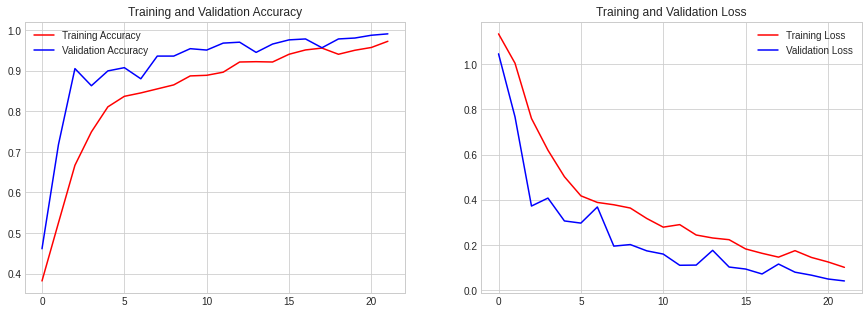

time: 20.6 s (started: 2022-09-02 12:11:50 +00:00)


In [ ]:
plot_history(history_simple)

# Evaluate the Basic Model

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=159,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle = False
)

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model_simple.predict_generator(validation_generator, steps = nb_samples)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = ['Rock', 'Paper', 'Scissors']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Found 876 images belonging to 3 classes.


Confusion Matrix
[[280   3   2]
 [  2 289   0]
 [  1   0 299]]
Classification Report
              precision    recall  f1-score   support

        Rock       0.99      0.98      0.99       285
       Paper       0.99      0.99      0.99       291
    Scissors       0.99      1.00      1.00       300

    accuracy                           0.99       876
   macro avg       0.99      0.99      0.99       876
weighted avg       0.99      0.99      0.99       876

time: 10.9 s (started: 2022-09-02 12:12:11 +00:00)


# Save the Basic Model for Deployment

In [ ]:
model_simple.save_weights('model_simple_weights.h5')
model_simple.save('model_simple.h5')

time: 159 ms (started: 2022-09-02 12:12:22 +00:00)


# Improve the Model Using Transfer Learning (InceptionV3)

In [ ]:
tf.keras.backend.clear_session()

model_inception = tf.keras.models.Sequential([
    InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_inception.layers[0].trainable = False

model_inception.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 31,242,019
Trainable params: 9,439,235
Non-trainable params: 21,802,784
_________________________________________________________________
time: 4.48 s (started: 2022-09-02 12:12:22 +00:00)


# Running the Transfer Learning Model Using InceptionV3

In [ ]:
model_inception.compile(
    optimizer = 'adam', 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

history_inception = model_inception.fit(
    train_generator,
    epochs=100,
    callbacks = [callbacks],
    verbose=1,
    validation_data=validation_generator
)

Epoch 1/100
11/11 [==============================] - 103s 9s/step - loss: 22.5163 - accuracy: 0.5099 - val_loss: 0.8939 - val_accuracy: 0.8961
Epoch 2/100
11/11 [==============================] - 95s 9s/step - loss: 1.6430 - accuracy: 0.8148 - val_loss: 0.1977 - val_accuracy: 0.9612
Epoch 3/100
11/11 [==============================] - 101s 9s/step - loss: 0.5926 - accuracy: 0.9200 - val_loss: 0.2418 - val_accuracy: 0.9498
Epoch 4/100
11/11 [==============================] - 97s 9s/step - loss: 0.3976 - accuracy: 0.9444 - val_loss: 0.0937 - val_accuracy: 0.9737
Epoch 5/100
11/11 [==============================] - 101s 9s/step - loss: 0.1690 - accuracy: 0.9611 - val_loss: 0.0964 - val_accuracy: 0.9703
Epoch 6/100
11/11 [==============================] - 100s 9s/step - loss: 0.1450 - accuracy: 0.9611 - val_loss: 0.0677 - val_accuracy: 0.9737
Epoch 7/100
11/11 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.9748
Akurasi di atas 97%, hentikan training!
11/11 [=======

# Visualize the Transfer Learning Model

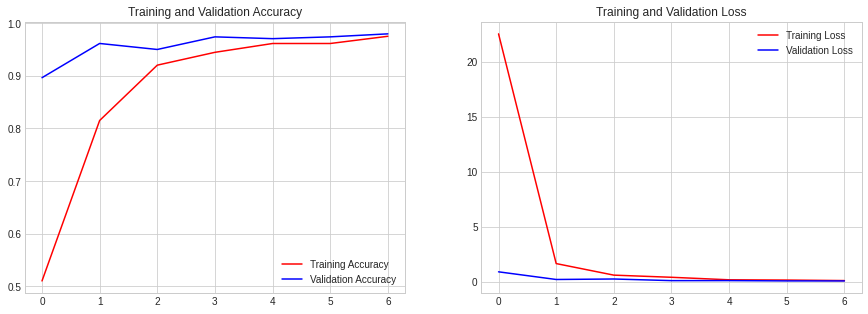

time: 389 ms (started: 2022-09-02 12:26:51 +00:00)


In [ ]:
plot_history(history_inception)

# Evaluate the Transfer Learning Model

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=159,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle = False
)

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model_inception.predict_generator(validation_generator, steps = nb_samples)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = ['Rock', 'Paper', 'Scissors']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Found 876 images belonging to 3 classes.


Confusion Matrix
[[270   6   9]
 [  0 291   0]
 [  1   2 297]]
Classification Report
              precision    recall  f1-score   support

        Rock       1.00      0.95      0.97       285
       Paper       0.97      1.00      0.99       291
    Scissors       0.97      0.99      0.98       300

    accuracy                           0.98       876
   macro avg       0.98      0.98      0.98       876
weighted avg       0.98      0.98      0.98       876

time: 39.3 s (started: 2022-09-02 12:26:51 +00:00)


# Save the Transfer Learning Model for Deployment

In [ ]:
model_inception.save_weights('model_inception_weights.h5')
model_inception.save('model_inception.h5')

time: 1.57 s (started: 2022-09-02 12:27:30 +00:00)


# Make Function for Predict Other Images

In [ ]:
def predict_image(image_upload, model = model_inception):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['Paper', 'Rock', 'Scissors']
  df['Product'] = prod
  df = df[['Product', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_product = 'Paper'
  elif predict_label == 1:
      predict_product = 'Rock'
  else:
      predict_product = 'Scissor'

  return predict_product, df

time: 7.48 ms (started: 2022-09-02 12:27:32 +00:00)


# Predict Image

Saving Rock-paper-scissors_(rock).png to Rock-paper-scissors_(rock).png




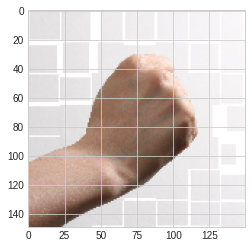


The image is detected as Rock


    Product  Probability
0     Paper     0.002871
1      Rock     0.995994
2  Scissors     0.001135


time: 4min 48s (started: 2022-09-02 12:27:32 +00:00)


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')